---
title: "Math function classifier with Pytorch"
author: "Jax Bulbrook"
date: "2023-07-18"
categories: [project]
---
FUTURE ME: This project was kinda a failure, I wouldn't try to follow it
The goal of this project is to be able to type in a math function and have it be graphed, then have a Neural Net try to predict the function with no knowledge of what it is. This is to help me learn Pytorch, as well as graphing tools like matplot.

# Helper functions

In [140]:
import numpy as np
import torch
import matplotlib.pyplot as plt # I had an error and had to also install ipywidgets in case you run into that
plt.style.use('_mpl-gallery')

In [141]:
def plot_func(func,num_points=2000,start=-5,stop=5):
    x = np.linspace(start,stop,num_points) # returns 2000 points evenly spaced from 1-100
    y = func(x)
    # plot
    fig, ax = plt.subplots()

    ax.plot(x, y, linewidth=2.0)

    ax.set(xlim=(start, stop), xticks=np.arange(start, stop),
           ylim=(start, stop), yticks=np.arange(start, stop))
    return x,y,ax 

In [142]:
def sin(x):
    return np.sin(x) 

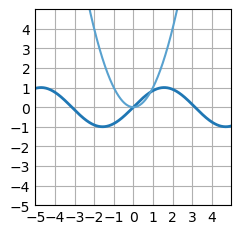

In [143]:
x,y,ax = plot_func(sin) # plot a function and get 2000 numbers from -5 to 5 with their corrosponding y values (also the axis to plot the predicted function on
ax.plot(x,x**2)
plt.show()

# Predictor, with only tensors and autoback
#### In order to predict the function, we need a series of steps:
1. Initialize random values.  
We are going to use an n-series polynomial. So we can pass in the number of polynomials, for example 3, and it will make a trinomial. So the predictor function would be ax^2 + bx + c, and abc would be the three parameters. I will write a function to do this now.

In [144]:
def make_params(num_params=4):
    return torch.randn(num_params, requires_grad=True) # requires grad is so we can do backpropogation later

In [145]:
def pred_func(params,x):
    y = torch.zeros_like(x)
    for (idx,param) in enumerate(params):
        y += param * x ** idx
    return y

tensor([ 0.6242, -0.1516,  0.1190, -0.2926], requires_grad=True)


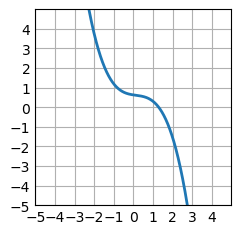

In [146]:
# test call
params = make_params()
print(params)
preds = pred_func(params,torch.from_numpy(x)) # convert numpy array to tensor
#ax.plot(x, preds.detach().numpy(), linewidth=2.0)
#plt.show()
start = -5
stop = 5
fig, ax = plt.subplots()

ax.plot(x, preds.detach().numpy(), linewidth=2.0)

ax.set(xlim=(start, stop), xticks=np.arange(start, stop),
       ylim=(start, stop), yticks=np.arange(start, stop))
plt.show()

# Now we have our prediction function, what about training?
The only thing that makes a neural network special is for it's ability to learn, so we need to implement backpropogation to teach it.

In [147]:
def update_params(params,learning_rate):
    with torch.no_grad():
        for param in params:
            param -= learning_rate * param.grad
            param.grad = None # manually zero the grad after updating weights

99 1897.98828125
199 924.3157958984375
299 521.1401977539062
399 350.1914978027344
499 273.97296142578125
599 236.58543395996094
699 215.29432678222656
799 200.8443145751953
899 189.45916748046875
999 179.59019470214844
1099 170.5946044921875
1199 162.19876098632812
1299 154.27919006347656
1399 146.77444458007812
1499 139.64865112304688
1599 132.87693786621094
1699 126.43931579589844
1799 120.31834411621094
1899 114.4981460571289
1999 108.96375274658203
2099 103.70096588134766
2199 98.69640350341797
2299 93.93749237060547
2399 89.4121322631836
2499 85.10885620117188
2599 81.01679992675781
2699 77.12552642822266
2799 73.42524719238281
2899 69.90657043457031
2999 66.560546875
3099 63.37876510620117
3199 60.35309600830078
3299 57.47591018676758
3399 54.73991394042969
3499 52.1381721496582
3599 49.66405487060547
3699 47.31141662597656
3799 45.074214935302734
3899 42.946773529052734
3999 40.92372512817383
4099 38.99995803833008
4199 37.17057418823242
4299 35.43095397949219
4399 33.776679992

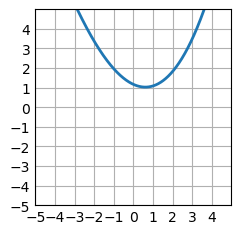

In [151]:
import torch.nn.functional as F
import torch.optim as optim

learning_rate = 1e-6
torch.set_default_tensor_type(torch.FloatTensor)
params = make_params()
x = torch.linspace(start, stop, steps=2000)
y = torch.sin(x)
optimizer = optim.SGD([params], lr=learning_rate)
for t in range(5000):
    # Forward pass: compute predicted y using operations on Tensors.
    preds = pred_func(params,x)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = F.mse_loss(preds, y) #(preds - y).pow(2).sum()
    if t % 100 == 99:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    optimizer.zero_grad()  # Zero the gradients before computing new ones
    loss.backward()       # Compute gradients
    optimizer.step()      # Update parameters using the optimizer

fig, ax = plt.subplots()

ax.plot(x, preds.detach().numpy(), linewidth=2.0)

ax.set(xlim=(start, stop), xticks=np.arange(start, stop),
       ylim=(start, stop), yticks=np.arange(start, stop))
plt.show()


# After getting it working with much struggle, we can now move onto moving everything into a class to make things much easier and more readable

In [202]:
class Net(torch.nn.Module):
    def __init__(self, num_params=3):
        super().__init__()
        self.num_params = num_params
        self.num_params = num_params
        self.params = torch.nn.Parameter(torch.randn(num_params) * 0.01)  # Manually initialize with small values
    def forward(self, x):
        y = torch.zeros_like(x)
        for idx in range(self.num_params):
            y += self.params[idx] * torch.pow(x, idx)
        return y

In [203]:
# Assuming x and y are your input data and target values respectively
x = torch.linspace(-5, 5, 2000)
y = torch.sin(x)

x = x.unsqueeze(1)  # Add a dimension to x to make it a 2D tensor (2000, 1)
y = y.unsqueeze(1)  # Add a dimension to y to make it a 2D tensor (2000, 1)


In [204]:
# Define the model, loss function, and optimizer
model = Net()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [205]:
for t in range(200):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

99 3.1718812266429933e+33
199 inf


# After a couple hours of work, it looks like this isn't going to work. I got it to work above, but I have no idea why the gradients are exploding here. I may try and come back later, but I actually still think this taught me a lot, as I now know how models work. I am going to go and try to make an actual model now.